# TP2:  Expectation-Maximisation algorithm – Importance sampling

# Exercice 1 : Discrete distributions

$Q_1$- Pour générer une variable aléatoire comme décrite dans l'exercice, il est nécéssaire d'utiliser l'inverse de la fonction de répartition, en effet la fonction de répartition de $X=\{x_1,...x_n\}$ est définie par :
$$F : t\in \mathbf{R} \longrightarrow \sum p_i\,\mathbf{1}_{t\geq x_i}$$
Donc l'inverse est défini par :
$$F^{-1} : u\in [0,1] \longrightarrow \sum x_i\,\mathbf{1}_{s_{j-1}\leq u\leq s_{j}}$$
avec $s_j=\sum_{i=0}^jp_i$. Alors la variable $Z$ définie par :
$$Z=\sum x_i\,\mathbf{1}_{[s_{j-1}, s_{j}[}(U)$$
Avec $U$ une loi uniforme sur $[0,1]$, suit la même loi que X.

$Q_2$- L'algorithme correspondant :

In [452]:
import numpy as np 
import matplotlib.pyplot as plt 
import pylab as pl
from matplotlib.patches import Ellipse

#fonction de rep d'une distrib p
def cumul(p):
    S = [0]
    n = len(p)
    for i in p:
        S.append(S[-1]+i)
    return np.array(S+[1])

#simulation
def draw(S,N):
    U = sorted(np.random.rand(N))
    X = []
    i = 1
    for u in U:
        while u >= S[i]:
             i += 1
        X.append(i)
    X = np.array(X)
    np.random.shuffle(X)
    return X

$Q_3$- Generation d'une suite de variable aléatoire $(Xi)_{i\in [1,N]}$􏰛  i.i.d qui ont la meme loi que X.

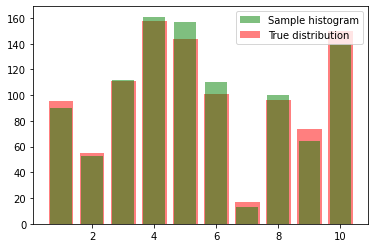

In [453]:
n = 10
N = 1000
p = np.random.rand(n)
p /= sum(p)
S = cumul(p)
X = draw(S, N)
pl.bar([1+i for i in range(n)], N*p, color='r', alpha=0.5, label='True distribution')
pl.hist(X, [0.5+i for i in range(n+1)], rwidth=0.7, color='g', alpha=0.5, label='Sample histogram')
pl.legend()
pl.show()

# Exercice 2 : Gaussian mixture model and the EM algorithm


$Q_1$- On a tout d'abord $X_i|\theta, (Z_i=j)\sim \mathcal{N}(\mu_j,\Sigma_j)$ et $P(Z_i=j)=\alpha_i$, la vraisemblance est définie par :
$$\mathcal{L}(x_1....x_n|\theta)=\prod_{i=1}^n f_{\theta}(x_i)$$
Calculons $f_{\theta}(x)=\sum_{j=1}^m\,P_{\theta}(z=j)P_{\theta}(x|z=j)=\sum_{i=1}^m\,\alpha_j \dfrac{1}{(2 \pi)^{d / 2} | \Sigma_j |^{1/2}} \exp \left( - \dfrac{1}{2} (x_i - \mu_j)^T \Sigma_j^{-1} (x_i - \mu_j) \right).$

Alors : $\log(\mathcal{L})=\sum_{i=1}^n log\left(\sum_{j=1}^m\alpha_j \dfrac{1}{(2 \pi)^{d / 2} | \Sigma_j |^{1/2}} \exp \left( - \dfrac{1}{2} (x_i - \mu_j)^T \Sigma_j^{-1} (x_i - \mu_j) \right)\right).$

$Q_2$- On va échantillonner un ensemble d'observations selon une loi de mélange gaussienne, on sait qu'une variable gausienne multivarié est définie par :
$$p(x|\mu,\Sigma)=\frac{1}{\sqrt{(2\pi)^d\,|\Sigma|}}exp(-\frac{1}{2}(x-\mu)^T\Sigma^{-1})(x-\mu))$$


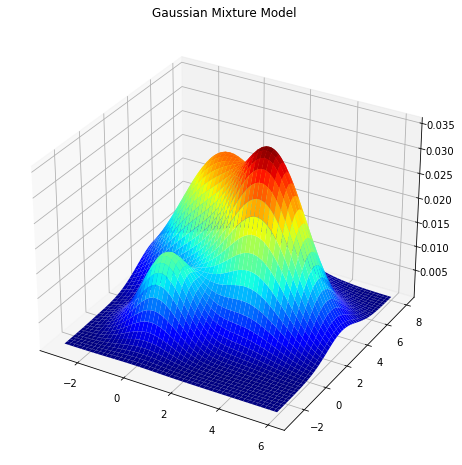

In [454]:
import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal as mvn
def f(x, y):
    z = np.column_stack([x.ravel(), y.ravel()])
    return (0.1*st.multivariate_normal([0,0], 1*np.eye(2)).pdf(z) +
            0.4*st.multivariate_normal([3,3], 2*np.eye(2)).pdf(z) +
            0.5*st.multivariate_normal([0,5], 3*np.eye(2)).pdf(z))
f(np.arange(3), np.arange(3))
s = 200
x = np.linspace(-3, 6, s)
y = np.linspace(-3, 8, s)
X, Y = np.meshgrid(x, y)
Z = np.reshape(f(X, Y), (s, s))

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='jet')
plt.title('Gaussian Mixture Model');



$Q_3$- L'algorithme EM


On commence par étudier l'étape E à l'étape t :
$$ \tau_{ij}^t = \mathbb{P}_{\theta_t}(Z_i = j \mid X_i = x_i) \sim \mathbb{P}_{\theta_t}(Z_i = j) f_{\theta_t}(X_i = x_i \mid Z_i = j) \sim  \dfrac{\alpha_j^t}{| \Sigma_j^t |^{1/2}} \exp \left( - \dfrac{1}{2} (x_i - \mu_j^t)^T \left( \Sigma_j^t \right)^{-1} (x_i - \mu_j^t) \right) $$ Puis pour l'étape M on veut maximiser Q défini par :
$$ Q(\theta \mid \theta_t) \sim \sum_{i = 1}^n \sum_{j = 1}^m \tau_{ij}^t \ln f_\theta(X_i = x_i, Z_i = j) \sim \sum_{i = 1}^n \sum_{j = 1}^m \tau_{ij}^t \left( \ln \alpha_j + \dfrac{1}{2} \ln \left| \Sigma_j^{-1} \right| - \dfrac{1}{2} (x_i - \mu_j)^T \Sigma_j^{-1} (x_i - \mu_j) \right) $$
On peut maximiser Q par rapport à $\alpha$ indépendament des autres paramètres via la Laplacien :
$$ L(\alpha, \nu) = \sum_{i = 1}^n \sum_{j = 1}^m \tau_{ij}^t \ln \alpha_j + \nu \left( 1 - \sum_{j = 1}^m \alpha_j \right) $$
On cherche alors quand le gradient selon $\alpha$ de L s'annule :
$$ \dfrac{\partial L}{\partial \alpha_j} = \sum_{i = 1}^n \dfrac{\tau_{ij}^t}{\alpha_j} - \nu = 0 \Leftrightarrow \alpha_j = \dfrac{1}{\nu} \sum_{i = 1}^n \tau_{ij}^t $$
Il suffit ensuite de normaliser via l'équation :
$$ \sum_{j = 1}^m \alpha_j = \dfrac{1}{\nu} \sum_{i = 1}^n \sum_{j = 1}^m \tau_{ij}^t = \dfrac{n}{\nu} = 1 $$
Donc :
$$ \alpha_j = \dfrac{1}{n} \sum_{i = 1}^n \tau_{ij}^t $$ Ensuite Q est concave en $\mu_j$. On calcule donc le gradient de Q par rapport à ce dernier qui doit être nul :
$$ \nabla_{\mu_j} Q = - \sum_{i = 1}^n \tau_{ij}^t \Sigma_j^{-1} (\mu_j - x_i) = 0 \Leftrightarrow \sum_{i = 1}^n \tau_{ij}^t (\mu_j - x_i) = 0 $$
Ce qui nous donne :
$$ \mu_j = \dfrac{1}{n \alpha_j} \sum_{i = 1}^n \tau_{ij}^t x_i $$ On fait de même pour $\Sigma_j^{−1}$ :
$$ \nabla_{\Sigma_j^{-1}} Q = \dfrac{1}{2} \sum_{i = 1}^n \tau_{ij}^t \left( \Sigma_j - (x_i - \mu_j) (x_i - \mu_j)^T \right) = 0 $$
Ce qui nous donne :
$$ \Sigma_j = \dfrac{1}{n \alpha_j} \sum_{i = 1}^n \tau_{ij}^t (x_i - \mu_j) (x_i - \mu_j)^T $$

In [455]:
#algo EM
def EM(X, alpha, mu, sigmas, tol=0.01, max_iter=100):
    n, p = X.shape
    k = len(alpha)

    ll_old = 0 #initialisation de la vraisemblance 
    for i in range(max_iter):
        ll_new = 0 ## la vraisemblance 

        # E-step
        tau_s = np.zeros((k, n))
        for j in range(len(mus)):
            for i in range(n):
                tau_s[j, i] = alpha[j] * mvn(mu[j], sigmas[j]).pdf(X[i])
        tau_s /= tau_s.sum(0)

        # M-step
        alpha = np.zeros(k)
        for j in range(len(mu)):
            for i in range(n):
                alpha[j] += tau_s[j, i]
        alpha /= n

        mu = np.zeros((k, p))
        for j in range(k):
            for i in range(n):
                mu[j] += tau_s[j, i] * X[i]
            mu[j] /= tau_s[j, :].sum()

        sigmas = np.zeros((k, p, p))
        for j in range(k):
            for i in range(n):
                ys = np.reshape(X[i]- mu[j], (2,1))
                sigmas[j] += tau_s[j, i] * np.dot(ys, ys.T)
            sigmas[j] /= tau_s[j,:].sum()

        # la vraisemblance
        ll_new = 0.0
        for i in range(n):
            s = 0
            for j in range(k):
                s += alpha[j] * mvn(mu[j], sigmas[j]).pdf(X[i])
            ll_new += np.log(s)

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new

    return ll_new, alpha, mu, sigmas

In [458]:
np.random.seed(123)

# create data set
n = 1000
_mus = np.array([[0,4], [-2,0]])
_sigmas = np.array([[[3, 0], [0, 0.5]], [[1,0],[0,2]]])
_alpha = np.array([0.6, 0.4])
xs = np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*n))
                    for pi, mu, sigma in zip(_alpha, _mus, _sigmas)])

# initial guesses for parameters
alpha = np.random.random(2)
alpha /= pis.sum()
mus = np.random.random((2,2))
sigmas = np.array([np.eye(2)] * 2)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: The following kwargs were not used by contour: 'N'
  


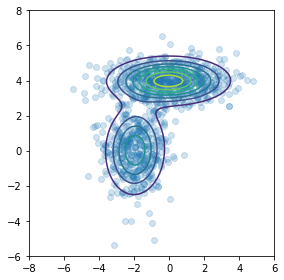

In [459]:
ll1, alpha1, mus1, sigmas1 = EM(xs, alpha, mus, sigmas)
intervals = 101
ys = np.linspace(-8,8,intervals)
X, Y = np.meshgrid(ys, ys)
_ys = np.vstack([X.ravel(), Y.ravel()]).T

z = np.zeros(len(_ys))
for pi, mu, sigma in zip(alpha1, mus1, sigmas1):
    z += pi*mvn(mu, sigma).pdf(_ys)
z = z.reshape((intervals, intervals))

ax = plt.subplot(111)
plt.scatter(xs[:,0], xs[:,1], alpha=0.2)
plt.contour(X, Y, z, N=10)
plt.axis([-8,6,-6,8])
ax.axes.set_aspect('equal')
plt.tight_layout()

$Q_4$ Comparaisons des mixtures :
Pour calculer les distances entre les mixtures je définie d'abord une distance entre les gaussiennes. J'utilise donc la  distance L2​ sur les paramètre de la gaussiennes :
$$ d_{L_2}^2 \left( \left( \alpha_0, \mu_0, \Sigma_0 \right), \left( \alpha_1, \mu_1, \Sigma_1 \right) \right) = \| \mu_0 - \mu_1 \|_2^2 \, + \, \left\| \sqrt{\Sigma_0} - \sqrt{\Sigma_1} \right\|_2^2 \, + \, \gamma . (\alpha_0 - \alpha_1)^2 $$
Où γ est une constante définie de sorte que le poids de la distance entre les α soit de l'ordre du poids des deux termes.

In [461]:
def sqrtm(A):
    """
    Retourne la racine carrée d une matrice 
    """
    v, w = np.linalg.eigh(A)
    return w @ np.diag(np.sqrt(v)) @ w.T
def mixture_dist_L2(alpha0, mu0, sigma0, alpha1, mu1, sigma1):
    """
    distance L2 entre deux gausiennes 
    """
    n, m = len(mu0), len(mu1)
    ds = np.array([[np.linalg.norm(sqrtm(sigma0[i]) - sqrtm(sigma1[j]))**2 for j in range(m)] for i in range(n)])
    ds += [[np.linalg.norm(mu0[i] - mu1[j])**2 for j in range(m)] for i in range(n)]
    ds += 0.5*np.amax(ds) * (alpha0.reshape(n, 1) - alpha1) ** 2
    e = 0.01 * ds.mean()
    return (ds-e).sum() ** 0.5

mixture_dist_L2(alpha ,mus  , sigmas, alpha1, mus1, sigmas1)


6.34128617837469

$Q_5$- Visualisation de  Crude Birth/Death Rate data 

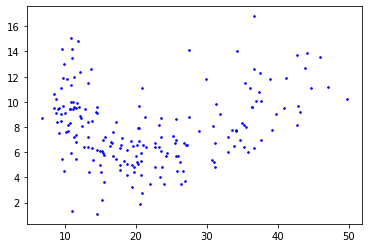

In [462]:
f = open("TP2_data.csv")
f.readline()
f.readline()
X = []
for l in f.readlines():
    l = l.replace('"', '').split(',')[1:]
    if '' in l: continue
    X.append(list(map(float, l)))
X = np.array(X)
pl.scatter(X[:,0], X[:,1], color='b', s=5e2/len(X))

$Q_6$- Estimation des paramètres $\theta$, et le calcul du BIC:

In [ ]:
#nombre de degrés de liberté du modèle de mélange avec m clusters.
def df(m):
    return m*5 + (m-1)

#Log- vraisemblance 
def logL(X, alpha, mu, sigma):
    n, d = X.shape
    m = len(alpha)
    log_l=0.0
    for i in range(n):
        s=0
        for j in range(d):
            s+=alpha[j] * mvn(mu[j], sigmas[j]).pdf(X[i])
        log_l += np.log(s)    
    return log_l

def BIC(X,alpha, mu, sigma, nSteps, maxM, nTry):
    n = len(X)
    maxM = min(n, maxM)
    bestS, bestM, bestT = float('inf'), 0, None
    for m in range(1, maxM+1):
        for _ in range(nTry):
            ll,alpha1, mu1, sigma1 = EM(X, alpha, mu, sigma)
            theta=alpha1, mu1, sigma1 
            L = logL(X, alpha1, mu1, sigma1)
            cost = -L + 0.5*df(m)*np.log(n)
            if cost < bestS:
                bestS, bestM, bestT = cost, m, theta
    return bestM, bestT

In [ ]:
pis = np.random.random(2)
pis /= pis.sum()
mus = np.random.random((2,2))
sigmas = np.array([np.eye(2)] * 2)

BIC(xs,pis, mus ,sigmas,nSteps=10, maxM=10, nTry=3)


La fonction BIC prend beaucoup de temps pour s'excuter, je n'arrive pas à trouver le problème.

# Exercice 3 : Importance sampling

# 3.A – Poor Importance Sampling

 $Q_1$ Implementation  du  simple importance scheme pour les fonctions $f, p$ et $q$.

In [463]:
def q(x):
    if x>0:
        return 2/(np.sqrt(2*np.pi*1.5)*np.exp((0.8-x)**2/(2*1.5)))
    else :
        return 0
def p(x):
    if x>0:
        return x**0.65*np.exp(x**2/2)
    else :
        return 0
def f(x):
    if x<0:
        return 0
    else:
        return 2*np.sin((np.pi*x)/1.5)
    
#imprtance sampling 
def IS(X,p,q,f):
    n=len(X)
    w=np.zeros(n)
    for i in range(n):
        w[i]+=p(X[i])/q(X[i])
    w/=w.sum(0)
    tau=np.zeros(n)
    for i in range(n):
        tau[i]+=w[i]*f(X[i])
    return np.sum(tau) 
#distribution de chi2
def dist_ki2(ddl, size):
    X = []
    x = np.random.normal(0,1,size)
    for _ in range(size):
        X.append(sum([n*n for n in np.random.choice(x,ddl)]))
    return X

$Q_2$-Comparaisons entre la moyenne exacte et celle estimé par l'importance sampling pour des tailles différentes de samples. 

In [464]:
# La moyenne recherché
def target_mean(X):
    n=len(X)
    K=[]
    for i in range(n):
        K.append(f(X[i]))
    target_mean=(np.mean(K))
    return target_mean

Num_sample=[10,100,1000,10000]
for i in Num_sample:
    X=dist_ki2(5,i)
    print('pour %d sample the target mean='%i,target_mean(X),'et la mean estimé  par l importance sampling est egale a',IS(X,p,q,f))


pour 10 sample the target mean= -0.06744944034832319 et la mean estimé  par l importance sampling est egale a -1.5870931085877513
pour 100 sample the target mean= 0.20987393887717165 et la mean estimé  par l importance sampling est egale a 0.3611806611785529
pour 1000 sample the target mean= 0.03205305187561083 et la mean estimé  par l importance sampling est egale a -0.7327725584189745
pour 10000 sample the target mean= -0.006767297214023156 et la mean estimé  par l importance sampling est egale a -1.8200543832139862


$Q_3$- On shift la moyenne de q, et on re-fait l'experience. 

In [465]:
def q_bis(x):
    if x>=0:
        return 2/np.sqrt(2*np.pi*1.5)*np.exp((6-x)**2/(2*1.5))
    else :
        return 0
#imprtance sampling 
def IS_bis(X,p,q,f):
    n=len(X)
    w=np.zeros(n)
    for i in range(n):
        w[i]+=p(X[i])/q_bis(X[i])
    w/=w.sum(0)
    tau=np.zeros(n)
    for i in range(n):
        tau[i]+=w[i]*f(X[i])
    return np.sum(tau)

In [466]:
#test 
for i in Num_sample:
    X=dist_ki2(5,i)
    print('pour %d sample the target mean='%i,target_mean(X),'et la mean estimé  par l importance sampling est egale a',IS_bis(X,p,q,f))



pour 10 sample the target mean= 0.11644298744831398 et la mean estimé  par l importance sampling est egale a -0.9460085578738442
pour 100 sample the target mean= -0.02425058740262634 et la mean estimé  par l importance sampling est egale a 0.9206977544974451
pour 1000 sample the target mean= -0.0091583762020622 et la mean estimé  par l importance sampling est egale a -1.6876931079511166
pour 10000 sample the target mean= -0.022390404155152525 et la mean estimé  par l importance sampling est egale a 0.9435910270512264


# Adaptative Importance Sampling

L'etape (iii) donnée dans l'algorithme Populations Monte Carlo peut etre résolu en utilisant l'algorithme EM, en effet en prenant $\tilde{w_i}= \tau_{i,j}$ de l'exercice précédent en utilisant le meme développement de l'exercice précédent, nous trouvons que l'algorithme EM est applicable à l'etape (iii).